In [ ]:
# Install dependencies listed in requirements.txt
%pip install -r requirements.txt

In [ ]:
# Load configs and API_KEYs
from config_loader import load_config

config = load_config()
print("✅ Config and secrets loaded successfully.")

# openAI API
OPENAI_API_KEY = config["OPENAI_API_KEY"]
if not OPENAI_API_KEY:
    raise RuntimeError("OPENAI_API_KEY missing. Add it to .env or set env vars.")

# Pinecone API
PINECONE_API_KEY = config["OPENAI_API_KEY"]
if not PINECONE_API_KEY:
    raise RuntimeError("PINECONE_API_KEY missing. Add it to .env or set env vars.")

# Logging - do NOT print the key
print("✅ API keys loaded (hidden).")

In [781]:
import os
import json
# Set environment variables for API keys - added to .env and loaded before
#os.environ["PINECONE_API_KEY"]=""
#os.environ["OPENAI_API_KEY"]=""

pinecone_api_key = os.environ.get('PINECONE_API_KEY')
openai_api_key = os.environ.get('OPENAI_API_KEY')

import operator
import datetime
from typing import Literal
from enum import Enum
from typing import Annotated, TypedDict
from langchain_pinecone import PineconeVectorStore
import pandas as pd
from langchain.chat_models import init_chat_model
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import OpenAIEmbeddings
from langgraph.constants import Send
from langgraph.graph import END, START, MessagesState, StateGraph
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [782]:
class AmountUnit(Enum):
    DOLLARS = "dollars"
    MILLIONS = "millions of dollars"
    BILLIONS = "billions of dollars"

class SharesUnit(Enum):
    ACTUAL = "actual"
    THOUSANDS = "thousands of shares"
    MILLIONS = "millions of shares"
    BILLIONS = "billions of shares"

class AbnormalExpense(BaseModel):
    """Nonrecurring, unusual, or abnormal expenses incurred by the firm"""
    description: str = Field(description="A one sentence summary of the abnormal expense")
    date: str = Field(description="The date when the expense was incurred.")
    fiscal_year: int = Field(description="The fiscal year when the expense was incurred.")
    amount: float = Field(description="The amount of the expense")
    unit: AmountUnit = Field(description="The units associated with the expense amount")
    type: Literal["Expense", "Revenue"]
    currency: str = Field(description="The currency in which the expense was incurred")
    impact_ni: Literal['y', 'n'] = Field(description="Does this item directly impact net income? y=yes, n=no")

class AbnormalExpenses(BaseModel):
    abnormal_expenses: list[AbnormalExpense] 

class FinancialMetrics(BaseModel):
    net_income: float = Field(description="Annual consolidated net income value")
    net_income_unit: AmountUnit = Field(description="Unit for net income (dollars, millions, billions)")
    tax_rate: float = Field(description="Effective tax rate in percentage")
    shares_out: float = Field(description="Basic weighted average number of shares outstanding")
    shares_out_unit: SharesUnit = Field(description="Unit for shares outstanding (actual, thousands, millions, billions)")
    stock_split_ratio_numeric: float = Field(description="Numeric split factor. Example: 4-for-1 would be 4.0. If no split, this is 1.0")

class ExtractState(MessagesState):
    """State for a single extraction"""
    context: Document
    abnormal_expenses: list
    year: int  # Add the year to the state
    temperature: float  # Add the temperature to the state
    model_name: str

class State(TypedDict):
    symbol: str  # Need the company's ticker to determine which RAG index to search
    year: int  # Will search a specific year's annual report (10-K)
    type: str  # Either '10-K' or '10-Q'
    model_name: str
    temperature: float  # Temperature for the language model
    n_contexts: int  # Number of context documents to keep from retrieval step 
    financial_context: list[Document]  
    expenses_context: list[Document]  # Add this field
    financial_metrics: FinancialMetrics
    abnormal_expenses: Annotated[list, operator.add]

class CoreEPSPrediction(BaseModel):
    next_year: int
    xgboost_core_eps_prediction: float
    random_forest_core_eps_prediction: float

In [783]:
def retrieve_financial_metrics(state: State):
    vector_store = PineconeVectorStore(index_name=pinecone_index, embedding=embeddings)
    net_income_query = f"Consolidated net income attributable to shareholders annual total for fiscal year {state['year']}"
    tax_rate_query = f"Effective tax rate annual for fiscal year {state['year']}"
    shares_query = f"Basic weighted average number of shares outstanding for fiscal year {state['year']}"
    split_query = f"Numeric stock split ratio for fiscal year {state['year']} (return only the number like 4 if 4-for-1, or 1 if no split occurred)"
    doc_filter = {"$and": [{"symbol": state["symbol"]}, {"year": state["year"]}, {"type":"10-K"}]}
    # Run searches
    net_income_contexts = vector_store.similarity_search(
        net_income_query, k=6, filter=doc_filter
    )
    tax_rate_contexts = vector_store.similarity_search(
        tax_rate_query, k=6, filter=doc_filter
    )
    shares_out_contexts = vector_store.similarity_search(
        shares_query, k=6, filter=doc_filter
    )
    split_contexts = vector_store.similarity_search(
        split_query, k=3, filter=doc_filter
    )
    # Combine the contexts
    financial_context = net_income_contexts + tax_rate_contexts + shares_out_contexts + split_contexts
    return {"financial_context": financial_context}


SYSTEM_PROMPT_FINANCIAL_METRICS = """
You are a financial data extraction specialist. Your task is to carefully extract specific financial metrics from the provided content for fiscal year {year}.

Please extract the following financial metrics:
 - Outstanding Shares: Report the latest number of common shares outstanding, typically found in the 'Consolidated Balance Sheets' or 'Earnings Per Share' section. provide only Class A shares outstanding only.
 - Net Income: Extract the most recent net income figure, usually reported in the 'Consolidated Statements of Income' or 'Financial Highlights' section.
 - Stock Split Ratio: If a stock split occurred during the year, extract only the numeric split ratio (for example, for a 4-for-1 split, return **4**). If no split occurred, return 1.

IMPORTANT: Never return zero values for net income or shares outstanding.

Return your findings as a JSON object with these exact keys: net_income, net_income_unit, tax_rate, shares_out, shares_out_unit, stock_split_ratio_numeric.

For net_income_unit, use one of: "dollars", "millions of dollars", "billions of dollars"
For shares_out_unit, use one of: "actual", "thousands of shares", "millions of shares", "billions of shares"

If no split occurred, return:
- stock_split_ratio_numeric: 1

Content for {year}:
{context}
"""

def extract_financial_metrics(state: State):  # Changed to use main State
    combined_content = "\n\n".join([doc.page_content for doc in state["financial_context"]])
    temp = state["temperature"]
    model_name = state["model_name"]
    llm = init_chat_model(model_name, temperature=temp, model_provider="openai")
    llm_metrics = llm.with_structured_output(FinancialMetrics)
    input_messages = [
        SystemMessage(content=SYSTEM_PROMPT_FINANCIAL_METRICS.format(context=combined_content, year=state["year"])),
        HumanMessage(
            content=f"Extract the annual Net Income, effective tax rate, basic weighted average number of shares outstanding for {state['year']} from the content."
        ),
    ]

    metrics = llm_metrics.invoke(input_messages)
    print(metrics)

    return {"financial_metrics": metrics}

In [784]:
SYSTEM_PROMPT_EXPENSES = """
As a financial analyst, your task is to identify **non-core, unusual, or one-time expenses and revenues** from the provided financial content for fiscal year {year}. These are items that do not relate to the companys regular, ongoing business operations and directly impact net income.

# Important Note:
Non-core items are often hidden or buried in **footnotes, accounting policy sections, or special disclosures**. Pay special attention to **footnotes** and **detailed explanatory notes** that accompany the financial statements, as these are frequent places where non-core expenses and revenues are disclosed.

# DO NOT INCLUDE regular operating expenses such as:
- Normal depreciation and amortization
- Regular operating expenses (payroll, rent, etc.)
- Routine inventory provisions
- Recurring R&D expenses
- Regular operating lease expenses
- Standard employee compensation
- Potential or hypothetical expenses with no specific amounts
- Items with zero amounts

# IMPORTANT RULES:
- Only include items with specific monetary amounts mentioned
- impact_ni must be 'y' if item affects net income, 'n' if it only impacts other comprehensive income/equity
- In financial reports, numbers are typically in millions unless specified otherwise

# For Each Item Found, Determine:
1. Description: A one sentence summary of the item
2. Date: When the expense or revenue was incurred (use the fiscal year end date if specific date is unknown)
3. Fiscal Year: {year}
4. Amount: The monetary value (always a positive number)
5. Unit: The currency unit (dollars, millions of dollars, or billions of dollars)
6. Type: "Expense" if it reduces net income (outflow), "Revenue" if it increases net income (inflow)
7. currency: The currency in which the expense was incurred
8. impact_ni: 'y' or 'n' (y=affects net income, n=affects other equity components)

# Deduplication
1. **Identify and remove or merge entries that describe THE SAME financial events**. For example: "gain on Sale" or "gain from a divestiture" may be the same financial event
2. Preserve entries with identical amounts/years but DIFFERENT underlying events

# CONTENT TO ANALYZE
{context}
""".strip()


In [785]:
def retrieve_expenses(state: State):
    vector_store = PineconeVectorStore(index_name=pinecone_index, embedding=embeddings)
    # Define the query we will use for similarity search
    query = f"unusual items, one-time events, non-recurring items, special charges, restructuring costs, asset impairments, gains or losses on asset sales, litigation expenses or discontinued operations for fiscal year {state['year']}"
    # Determine how many documents to return from the search
    n_contexts = state.get("n_contexts", 5)
    # Run the search
    expenses_context = vector_store.similarity_search(
        query, k=n_contexts, filter={"$and": [{"symbol": state["symbol"]}, {"year": state["year"]}, {"type": "10-K"}]}
    )
    return {"expenses_context": expenses_context}

def extract_expenses_one_context(state: ExtractState):
    temp = state["temperature"]
    model_name = state["model_name"]
    llm = init_chat_model(model_name, temperature=temp, model_provider="openai")
    llm_expenses = llm.with_structured_output(AbnormalExpenses)

    input_messages = [
        SystemMessage(content=SYSTEM_PROMPT_EXPENSES.format(
            context=state["context"].page_content,
            year=state["year"]
        )),
        HumanMessage(
            content=f"Identify and extract any abnormal, non recurring, or unusual expenses or revenue items for {state['year']}. Be sure to classify each item explicitly as either 'Expense' or 'Revenue'."
        ),
    ]

    expenses = llm_expenses.invoke(input_messages)
    
    all_expenses = []
    for expense in expenses.abnormal_expenses:
        if expense.fiscal_year == state["year"]:
            #print(expense.model_dump(mode="json"))
            record = expense.model_dump(mode="json")
            record["source"] = state["context"].id
            all_expenses.append(record)

    return {"abnormal_expenses": all_expenses}

def initiate_expense_extraction(state: State):
    """This is the "map" step when we initiate an extraction for every piece of context in the main workflow state"""
    # "Send" each piece of context to the function `extract_expenses_one_context` in parallel
    return [Send("extract_expenses_one_context", {"context": doc, "year": state["year"], "temperature": state["temperature"], "model_name": state["model_name"]}) for doc in state["expenses_context"]]

In [786]:
def format_output(state: State):
    csv_data = []
    run_id = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

    #Deduplication code:
    # llm query parameters
    temp = state["temperature"]
    model_name = state["model_name"]
    llm = init_chat_model(model_name, temperature=temp, model_provider="openai")

    # Step 1: Convert abnormal expenses list to JSON table format
    print("Step 1: Converting abnormal expenses to JSON table")
    json_table = json.dumps(state.get("abnormal_expenses", []), indent=2)

    # Step 2: Configure LLM for structured output
    print("Step 2: Configuring structured output")
    llm_with_structured = llm.with_structured_output(AbnormalExpenses)

    # Step 3: Define input messages
    print("Step 3: Creating input messages")
    input_messages = [
        SystemMessage(content=SYSTEM_PROMPT_EXPENSES.format(
            context=json_table,
            year=state["year"]
        )),
        HumanMessage(
            content=f"Identify and remove duplicate events based on the 'description' field for {state['year']}. "
                    "If two events have the same description but different amounts, keep only one."
                    "Return the cleaned data in the same JSON structure."
        ),
    ]

    # Step 4: Invoke LLM with structured output
    print("Step 4: Calling LLM for deduplication")
    deduplicated_expenses = llm_with_structured.invoke(input_messages)

    # Step 5: Convert response to return
    print("Step 5: Converting response to DataFrame")
    if isinstance(deduplicated_expenses, AbnormalExpenses):
       
        # Convert to dictionary while ensuring proper JSON serialization
        response_dict = deduplicated_expenses.model_dump(mode="json")
        # Ensure the structure is the same as input (list inside "abnormal_expenses" key)
        final_response = {
            "abnormal_expenses": response_dict["abnormal_expenses"]  # Maintain the same structure
        }
        print(json.dumps(final_response, indent=2))

        #return updated expenses
        state["abnormal_expenses"] = deduplicated_expenses
    else:
        print("Error: Unexpected LLM output format", deduplicated_expenses)
    
    #Format output code:
    if not state.get("abnormal_expenses"):
        ni = state["financial_metrics"].net_income
        unit_ni = state["financial_metrics"].net_income_unit

        ni_dollar = ni

        if unit_ni == AmountUnit.MILLIONS:
            ni_dollar = ni * 1_000_000
        elif unit_ni == AmountUnit.BILLIONS:
            ni_dollar = ni * 1_000_000_000

        shares = state["financial_metrics"].shares_out
        unit_shares = state["financial_metrics"].shares_out_unit

        shares_out = shares

        if unit_shares == SharesUnit.THOUSANDS:
            shares_out = shares * 1_000
        elif unit_shares == SharesUnit.MILLIONS:
            shares_out = shares * 1_000_000
        elif unit_shares == SharesUnit.BILLIONS:
            shares_out = shares * 1_000_000_000

        csv_data.append({
            "run_id": run_id,
            "ticker": state["symbol"],
            "year": state["year"],
            "temperature": state["temperature"],
            "model_name": state["model_name"],
            "net_income": ni_dollar,
            "tax_rate": state["financial_metrics"].tax_rate,
            "shares_out": shares_out,
            "stock_split": state["financial_metrics"].stock_split_ratio_numeric,
            "abnormal_expense_description": None,
            "type": None, 
            "impact_ni": None, 
            "pre_tax_amount": 0,
            "post_tax_amount": 0,
            "currency": None
            })

    else:
        for expense in state.get("abnormal_expenses", []):
            amount = expense["amount"]
            unit = expense["unit"]

            # Convert to dollars
            if isinstance(unit, AmountUnit):
                if unit == AmountUnit.MILLIONS:
                    amount_dollars = amount * 1_000_000
                elif unit == AmountUnit.BILLIONS:
                    amount_dollars = amount * 1_000_000_000
                else:
                    amount_dollars = amount
            elif isinstance(unit, str):
                if "million" in unit.lower():
                    amount_dollars = amount * 1_000_000
                elif "billion" in unit.lower():
                    amount_dollars = amount * 1_000_000_000
                else:
                    amount_dollars = amount
            else:
                amount_dollars = amount

            # Skip entries with zero amounts
            if amount_dollars == 0:
                continue

            tax_rate = state["financial_metrics"].tax_rate / 100
            after_tax_impact = amount_dollars * (1 - tax_rate)

            ni = state["financial_metrics"].net_income
            unit_ni = state["financial_metrics"].net_income_unit

            ni_dollar = ni

            if unit_ni == AmountUnit.MILLIONS:
                ni_dollar = ni * 1_000_000
            elif unit_ni == AmountUnit.BILLIONS:
                ni_dollar = ni * 1_000_000_000

            shares = state["financial_metrics"].shares_out
            unit_shares = state["financial_metrics"].shares_out_unit

            shares_out = shares

            if unit_shares == SharesUnit.THOUSANDS:
                shares_out = shares * 1_000
            elif unit_shares == SharesUnit.MILLIONS:
                shares_out = shares * 1_000_000
            elif unit_shares == SharesUnit.BILLIONS:
                shares_out = shares * 1_000_000_000

            csv_data.append({
                "run_id": run_id,
                "ticker": state["symbol"],
                "year": state["year"],
                "temperature": state["temperature"],
                "model_name": state["model_name"],
                "net_income": ni_dollar,
                "tax_rate": state["financial_metrics"].tax_rate,
                "shares_out": shares_out,
                "stock_split": state["financial_metrics"].stock_split_ratio_numeric,
                "abnormal_expense_description": expense["description"],
                "type": expense["type"], 
                "impact_ni": expense["impact_ni"], 
                "pre_tax_amount": amount_dollars,
                "post_tax_amount": after_tax_impact,
                "currency": expense["currency"]
            })

    file_exists = os.path.exists(csv_file)

    if csv_data:
        df = pd.DataFrame(csv_data)
        df.to_csv(csv_file, mode="a", index=False, header=not file_exists)

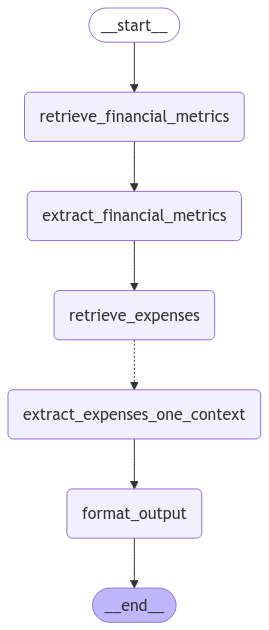

In [787]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("retrieve_financial_metrics", retrieve_financial_metrics)
workflow.add_node("extract_financial_metrics", extract_financial_metrics)
workflow.add_node("retrieve_expenses", retrieve_expenses)
workflow.add_node("extract_expenses_one_context", extract_expenses_one_context)
workflow.add_node("format_output", format_output)

# Add edges
workflow.add_edge(START, "retrieve_financial_metrics")
workflow.add_edge("retrieve_financial_metrics", "extract_financial_metrics")
workflow.add_edge("extract_financial_metrics", "retrieve_expenses")
workflow.add_conditional_edges("retrieve_expenses", initiate_expense_extraction, ["extract_expenses_one_context"])
workflow.add_edge("extract_expenses_one_context", "format_output")
workflow.add_edge("format_output", END)

# Compile
compiled_workflow = workflow.compile()
compiled_workflow

In [788]:
# Applies the workflow to all companies in our database, for the years we have data availability
ticker_year = {
    "ACN": 2017,
    #"JKHY": 2016
}

for ticker, year in ticker_year.items():
    state = {
        "symbol": ticker,
        "year": year,
        "type": "10-K",
        "n_contexts": 10,
        "temperature": 0,
        "model_name": "gpt-4o-mini"
    }
    result = compiled_workflow.invoke(state)

net_income=715.0 net_income_unit=<AmountUnit.MILLIONS: 'millions of dollars'> tax_rate=21.3 shares_out=400000000.0 shares_out_unit=<SharesUnit.ACTUAL: 'actual'> stock_split_ratio_numeric=1.0
Step 1: Converting abnormal expenses to JSON table
Step 2: Configuring structured output
Step 3: Creating input messages
Step 4: Calling LLM for deduplication
Step 5: Converting response to DataFrame


TypeError: 'AbnormalExpenses' object is not subscriptable